In [4]:

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import copy
import time
import os

from numpy.lib import stride_tricks
%matplotlib inline
import OceanPSC.operations as op
from OceanPSC.utils import load_data
from OceanPSC.Map import Map

import importlib
import random
from skimage.measure import block_reduce
import cv2
import copy
import OceanPSC.DEM as d
import OceanPSC.classification as c
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage,fcluster

In [264]:
dem=c.default_dem()
final_classes=c.get_sea_classification(curvature=dem.curvature,slope=dem.slope,elevation=dem.elevation,
                                 organization=dem.organization,roughness=dem.roughness)

csh cleaned!
cslope cleaned!
c_rise cleaned!


AttributeError: 'function' object has no attribute 'sum'

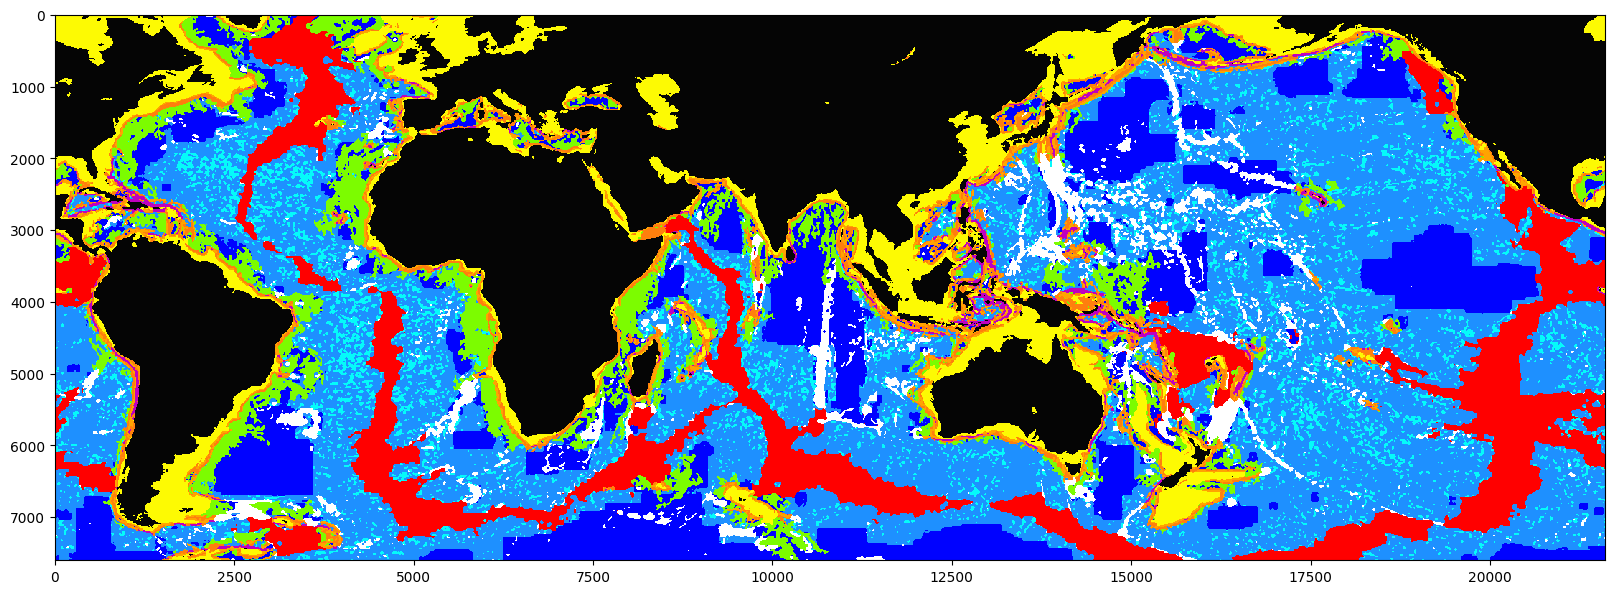

In [20]:
plt.figure(figsize=(20,10),dpi=100)
plt.imshow(nclasses,cmap=c.class_color_map,interpolation='nearest')

In [7]:

display=(rr<0)*0.6*(rr)/(-np.min(rr))+(rr>=0)*(0.6+0.4*rr/np.max(rr))
ndisplay=cm.jet(plt.Normalize()(display))
ndisplay=ndisplay[:,:,:-1]

rr=rr-np.min(rr)

fclasses=c.class_color_map(plt.Normalize()(nclasses))
fclasses=fclasses[:,:,:-1]

In [9]:
import tensorflow as tf

In [3]:
def dens(cla,axis):
    rsl=np.zeros((cla.shape[0],cla.shape[1],11))
    for i in range(11):
        rsl[:,:,i]=(cla==i).mean(axis=axis)
    return rsl

In [6]:

cll=block_reduce(classes,(5,5),dens)
fin_c=np.argmax(cll,axis=-1)

In [61]:

def reduce(data,redux=2):
    dta=block_reduce(data,(redux,redux),np.mean)>0
    datf=np.zeros_like(fin_c)
    I,J=np.where(dta)
    datf[redux*I,redux*J]=1
    datf=datf>0
    return datf

In [ ]:
freqs=dens(op.neighbor_grid(fin_c,neighbor_dist=7),axis=(-1,-2))

In [1]:
import numpy as np

In [6]:
np.argmax(np.random.rand(5,5)<0)

In [22]:
np.argmax(np.hstack([np.zeros((5,1)),np.random.rand(5,5)<0.2]),axis=-1)-1

array([-1,  2, -1,  0,  1], dtype=int64)

In [9]:
I,J

(array([0, 1, 1, 2, 2, 3, 3, 4, 4, 4], dtype=int64),
 array([0, 3, 4, 3, 4, 0, 4, 0, 2, 4], dtype=int64))

In [10]:
J[I]

array([0, 3, 3, 4, 4, 3, 3, 4, 4, 4], dtype=int64)

In [174]:


full_coast=(freqs[:,:,c.CONTINENTAL_SHELF]==1)
full_c_rise=(freqs[:,:,c.CONTINENTAL_RISE]>0.65)&((freqs[:,:,c.ABYSSAL_PLAIN]+freqs[:,:,c.CONTINENTAL_RISE])>0.97)
full_abp=(freqs[:,:,c.ABYSSAL_PLAIN]==1)
full_rs=(freqs[:,:,c.ROUGH_SEAFLOOR]>0.8)&((freqs[:,:,c.ROUGH_SEAFLOOR]+freqs[:,:,c.VERY_ROUGH_SEAFLOOR])==1)
full_vrs=(freqs[:,:,c.VERY_ROUGH_SEAFLOOR]>0.4)&((freqs[:,:,c.ROUGH_SEAFLOOR]+freqs[:,:,c.VERY_ROUGH_SEAFLOOR])==1)
full_mor=(freqs[:,:,c.MID_OCEANIC_RIDGE]==1)
land_coast=(freqs[:,:,c.CONTINENTAL_SHELF]>0.35)&(freqs[:,:,c.LAND]>0.35)



passive_slope=(freqs[:,:,c.CONTINENTAL_RISE]>0.1)&(freqs[:,:,c.CONTINENTAL_SHELF]>0.2)
passive_slope=passive_slope&((freqs[:,:,c.LOWER_CONTINENTAL_SLOPE]+freqs[:,:,c.UPPER_CONTINENTAL_SLOPE])>0.3)
passive_slope=passive_slope&(freqs[:,:,c.SCARPS]<0.01)
passive_slope=passive_slope&((freqs[:,:,c.CONTINENTAL_SHELF]+freqs[:,:,c.UPPER_CONTINENTAL_SLOPE]+
                              freqs[:,:,c.LOWER_CONTINENTAL_SLOPE]+freqs[:,:,c.CONTINENTAL_RISE])>0.8)
passive_slope=passive_slope&((freqs[:,:,c.ROUGH_SEAFLOOR]+freqs[:,:,c.VERY_ROUGH_SEAFLOOR])<0.05)

active_slope=((freqs[:,:,c.LAND]+freqs[:,:,c.CONTINENTAL_SHELF])>0.15)&((freqs[:,:,c.LOWER_CONTINENTAL_SLOPE]+
                                                                        freqs[:,:,c.UPPER_CONTINENTAL_SLOPE]+
                                                                        freqs[:,:,c.SCARPS])>0.3)
active_slope=active_slope&(freqs[:,:,c.SCARPS]>0.1)&(freqs[:,:,c.CONTINENTAL_RISE]<0.05)
active_slope=active_slope&((freqs[:,:,c.ROUGH_SEAFLOOR]+freqs[:,:,c.VERY_ROUGH_SEAFLOOR]+freqs[:,:,c.ABYSSAL_PLAIN])>0.1)



seamount_in_abp=(freqs[:,:,c.ABYSSAL_PLAIN]>0.4)&(freqs[:,:,c.SEAMOUNT]>0.3)&((freqs[:,:,c.ABYSSAL_PLAIN]+
                                                                               freqs[:,:,c.SEAMOUNT])>0.95)
seamount_in_rs=((freqs[:,:,c.ROUGH_SEAFLOOR]+freqs[:,:,c.VERY_ROUGH_SEAFLOOR])>0.4)&(freqs[:,:,c.SEAMOUNT]>0.3)



In [175]:
full_c_rise.sum()

14554

In [176]:
rsl=[]
categs=[full_coast,full_abp,full_c_rise,full_mor,full_rs,full_vrs,land_coast,
        passive_slope,active_slope,seamount_in_abp,seamount_in_rs]
for k in range(len(categs)):
    if (categs[k]).sum()>40000 and reduce(categs[k],4).sum()>7500:
        categs[k]=reduce(categs[k],4)
    elif (categs[k]).sum()>20000 and reduce(categs[k]).sum()>7500:
        categs[k]=reduce(categs[k])
    rsl.append([names[k],categs[k].sum()])
pd.DataFrame(rsl,columns=['type','nombre d\'échantillons'])

,type,nombre d'échantillons
0,csh,14796
1,abp,16696
2,cr,14554
3,mor,15299
4,rs,12167
5,vrs,12264
6,land_csh,8556
7,passive_margin,5564
8,active_margin,4966
9,s_abp,4829


In [28]:
os.listdir('dataset')

In [26]:
import tensorflow as tf

In [25]:
import os

In [5]:
names=['csh','abp','cr','mor','rs','vrs','land_csh',
        'passive_margin','active_margin','s_abp','s_rs']

In [71]:
rr2prime=np.zeros((rr.shape[0],rr.shape[1]+148))
rr2prime[:,0:rr.shape[1]]=rr
rr2prime[:,148:]=rr
rr2prime=np.int32(rr2prime)
everything=op.neighbor_grid(rr2prime,neighbor_dist=74)
everything=everything[600:-600,74:-74,:,:]

In [181]:
dset={}
set_size=10000

angles=[0,cv2.ROTATE_90_CLOCKWISE,cv2.ROTATE_180,cv2.ROTATE_90_COUNTERCLOCKWISE]

for j in range(len(categs)):
    I,J=np.where(categs[j])
    points=np.array([I,J]).T
    sel_points=np.array(random.choices(points,k=set_size))
    sel_angles=np.random.choice(angles,size=set_size)
    indexes=np.arange(set_size)
    dset[names[j]]=np.hstack((indexes[:,None],sel_points,sel_angles[:,None]))

In [20]:
for name in names:
    os.mkdir(f'dataset/{name}')

In [182]:
for key in dset:
    content=dset[key]
    for entry in content:
        index=entry[0]
        i=entry[1]
        j=entry[2]
        angle=entry[3]
        
        save_path=f'dataset/{key}/img{index}.npy'
        img=np.float32(everything[i*10,j*10])
        img=cv2.rotate(img,angle)
        img=cv2.resize(img,(128,128))
        np.save(save_path,img)

In [279]:
tab=np.zeros((10,10))

In [281]:
tab[:,:,None].shape

(10, 10, 1)

In [29]:
maxi=-50000
mini= 50000
for name in names:
    means=[]
    stds=[]
    for k in range(10000):
        file=f'dataset/{name}/img{k}.npy'
        data=np.float32(np.load(file))
        if np.max(data)>maxi:
            maxi=np.max(data)
        if np.min(data)<mini:
            mini=np.min(data)
        means.append(data.mean())
        stds.append(np.std(data))
    print(name,np.median(np.array(means)),np.median(np.array(stds)))

abp -4885.5625 113.98505
active_margin -2226.8826 1616.9661
cr -3773.454 300.1272
csh -120.57302 38.313534
land_csh 16.424103 196.56406
mor -3165.3884 275.57648
passive_margin -1500.5594 861.6871
rs -4748.0747 195.672
s_abp -4138.1006 781.932
s_rs -4515.673 779.889
vrs -5005.4707 270.19873


In [2]:
maxi,mini

(5307.6294, -10760.56)

In [21]:
for name in names:
    for k in range(10000):
        file=f'dataset/{name}/img{k}.npy'
        data=np.float32(np.load(file))
        data=(data-mini)/(maxi-mini)
        data=np.uint16(data*(2**16-1))[:,:,None]
        save_path=f'train/{name}/'+'{:04d}.png'.format(k)
        tf.io.write_file(save_path,tf.io.encode_png(data))
        

In [ ]:
for k in range(10):
    plt.figure(figsize=(20,10),dpi=100)
    img=np.load(f'dataset/abp/img{int(set_size*random.random())}.npy')
    plt.title(f'{np.max(img)},{np.min(img)}')
    plt.imshow(img,cmap='gray')